# Combining Scores

In this notebook, we train a ResNet model with stretched images to correctly classify with high accuracy whether an image contains an invasive species of hydrangea.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [154]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100
model_save_dir = os.path.join(cwd,"model_params_scaling.pth")


In [14]:
print(dset_classes)

['0', '1']


## Image sample
Plot an image just to make sure we have something that makes sense.

In [147]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    img = to_pil(inp)
    plt.imshow(img)

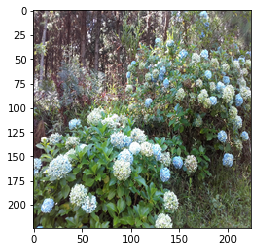

In [108]:
inputs, classes = next(iter(dset_loaders['train']))
show_img(inputs[0])

## Training
We use the following helper function to help us train a model.

In [226]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, return_errors=False, is_testing=False):
    if not is_testing:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        scores = model(x_var)
        prob_score = softmax_fn(scores).data.cpu()
        #print(prob_score.size())
        #print(y)
        #print(prob_score[0,y])
        #raise
        #all_probs = torch.cat([correct_probs.squeeze(1), incorrect_probs.squeeze(1)], 1)
        #prob_scores.append(prob_score.index.data.cpu())
        #prob_scores.append(prob_score)

        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if return_errors:
            for i,x_i in enumerate(x):
                if (preds[i]!=y[i])[0] == 1:
                    incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
                prob_scores_corr.append(prob_score[i][y[i]])
                prob_scores_incorr.append(prob_score[i][1-y[i]])

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr

In [152]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

In [135]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
model.load_state_dict(torch.load(model_save_dir))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-4.55194, betas=(0.95, 0.995), weight_decay=0.00186)

In [110]:
acc, incorrects = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 431 / 439 correct (98.18)
False negatives: 5
False positives: 3


In [112]:
acc, incorrects_train = check_accuracy(model, dset_loaders["train"], True, False)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 1848 / 1856 correct (99.57)
False negatives: 5
False positives: 3


Now let's train again on these incorrectly classified images from the training set.

In [136]:
all_inc = []
all_inc.extend(incorrects_train[0])
all_inc.extend(incorrects_train[1])
inc_dataset = torch.cat(all_inc, 0)
targets = torch.cat([torch.LongTensor(len(incorrects_train[0])).fill_(1), torch.LongTensor(len(incorrects_train[1])).fill_(0)], 0)

In [137]:
train_incorr = torch.utils.data.TensorDataset(inc_dataset, targets)
train_incorr_loader = torch.utils.data.DataLoader(train_incorr, batch_size=4, shuffle=True)

In [138]:
all_inc_val = []
all_inc_val.extend(incorrects[0])
all_inc_val.extend(incorrects[1])
inc_dataset_val = torch.cat(all_inc_val, 0)
targets_val = torch.cat([torch.LongTensor(len(incorrects[0])).fill_(1), torch.LongTensor(len(incorrects[1])).fill_(0)], 0)
incorr_val = torch.utils.data.TensorDataset(inc_dataset_val, targets_val)
incorr_loader_val = torch.utils.data.DataLoader(incorr_val, batch_size=4, shuffle=True)

In [139]:
optimizer = optim.Adam(model.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=0.00186)
loss_history_after = train(model, loss_fn, train_incorr_loader, optimizer, num_epochs=5)
acc, incorrects_after = check_accuracy(model, incorr_loader_val, True)
print("False negatives:",len(incorrects_after[0]))
print("False positives:",len(incorrects_after[1]))

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Checking accuracy on validation set
Got 4 / 8 correct (50.00)
False negatives: 2
False positives: 2


In [140]:
acc, incorrects_val = check_accuracy(model, dset_loaders['val'], True)
print("False negatives:",len(incorrects_val[0]))
print("False positives:",len(incorrects_val[1]))

Checking accuracy on validation set
Got 430 / 439 correct (97.95)
False negatives: 2
False positives: 2


In [156]:
model_inc_save_dir = os.path.join(cwd,"model_params_extra_incor2.pth")
torch.save(model.state_dict(), model_inc_save_dir)

Instead let's try training on the harder validation images.

In [141]:
model.load_state_dict(torch.load(model_inc_save_dir))
acc, incorrects_val = check_accuracy(model, dset_loaders['val'], True)
print("False negatives:",len(incorrects_val[0]))
print("False positives:",len(incorrects_val[1]))

Checking accuracy on validation set
Got 436 / 439 correct (99.32)
False negatives: 2
False positives: 1


## False Positives and False Negatives
Here we plot all of the false positives and false negatives.

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


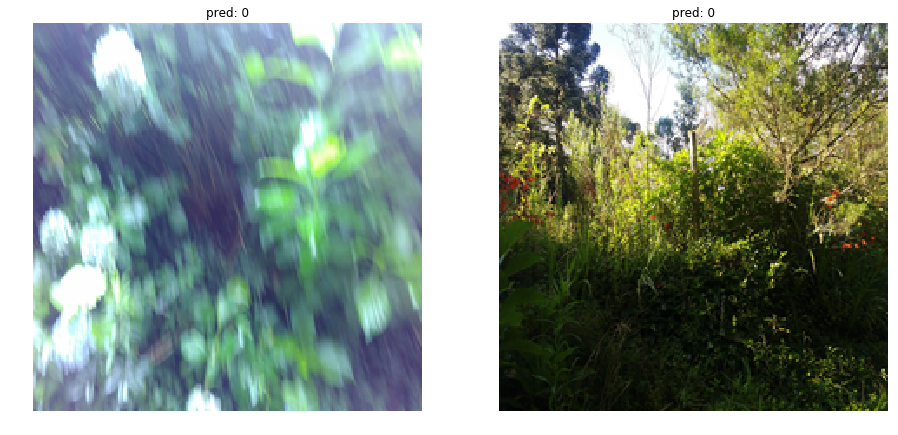

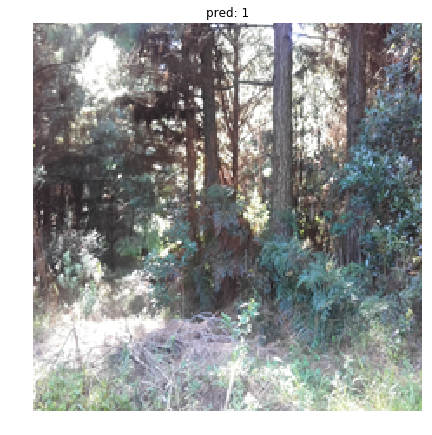

In [146]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//4+1, 4, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        show_img(imgs[j])

plot_images([x.squeeze(0) for x in incorrects_val[0]], "0")
plot_images([x.squeeze(0) for x in incorrects_val[1]], "1")

Now that it's a bit better, let's try the test set again.

In [150]:
from TestModel import TestModel

TestModel(model).submit()

Submission complete!


Test results: 0.95841 -> 0.95976

Clearly we need to try something else!

## Output probabilities instead of exact scores
We can get partial "credit" from the Kaggle interpreter for outputting probabilities instead of binary classifications. Let's try that instead.

In [231]:
acc, incorrects, prob_scores_corr, prob_scores_incorr = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 222 / 226 correct (98.23)
False negatives: 2
False positives: 2


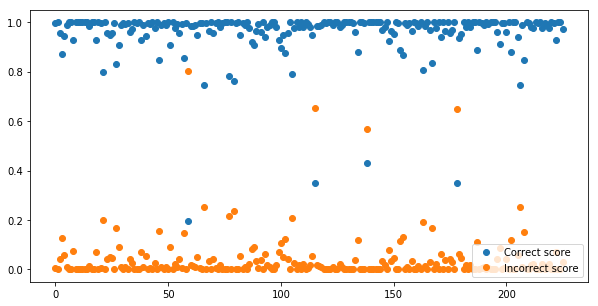

In [232]:
plt.plot(prob_scores_corr, 'o', label='Correct score')
plt.plot(prob_scores_incorr, 'o', label='Incorrect score')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()

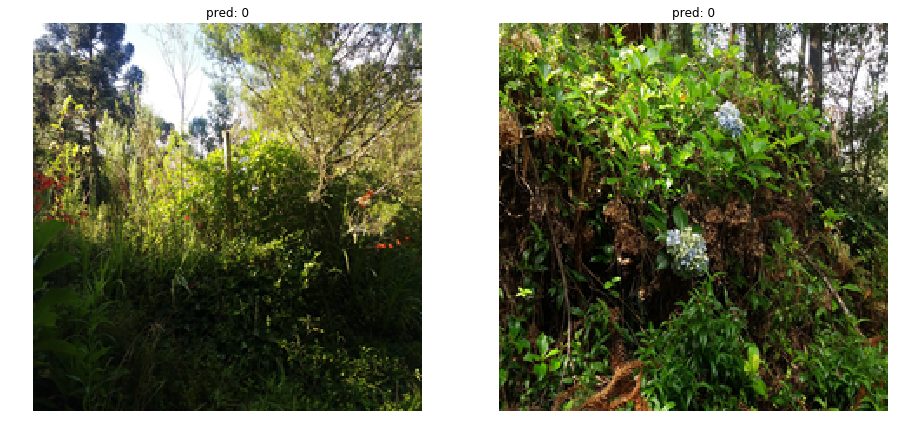

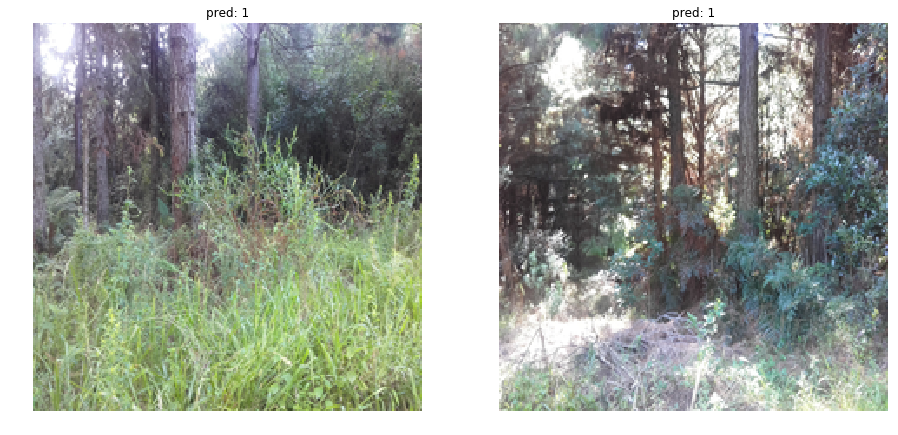

In [233]:
plot_images([x.squeeze(0) for x in incorrects[0]], "0")
plot_images([x.squeeze(0) for x in incorrects[1]], "1")

In [235]:
from TestModel import TestModel

TestModel(model, use_probs=True).send_to_kaggle("test_probs.csv", "test with probs")

Test results: 0.98812 (from 0.95841!)